In [110]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
# tf.enable_eager_execution()
tf.VERSION

'1.13.1'

In [111]:
import pathlib
import os

# reuse this when necessary
directory = "./train/"
nameList = os.listdir(directory)
imageNames = []
for f in nameList:
    if "resized" in f:
        imageNames.append(f)

In [118]:
import random
random.shuffle(imageNames)

image_count = len(imageNames)
image_count

filePaths = []
for f in imageNames:
    filePaths.append(directory+f)

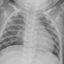

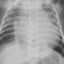

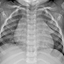

In [119]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(filePaths)
    display.display(display.Image(image_path))
    print

In [120]:
label_names = ["pneumonia", "normal"]
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'normal': 1, 'pneumonia': 0}

In [121]:
all_labels = []
for f in filePaths:
    if "normal" in f:
        all_labels.append(1)
    elif "pneumonia" in f:
        all_labels.append(0)
    
if len(all_labels) != len(filePaths):
    print("Not working")
else: 
    print ("all set")

print(all_labels[:10])

all set
[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [126]:
img_path = filePaths[0]
img_raw = tf.read_file(img_path)
# img_raw
img_tensor = tf.cast(tf.image.decode_image(img_raw),tf.float32)
img_tensor.shape
tmpSess = tf.Session()
img_tensor = img_tensor.eval(session=tmpSess)
# tempSess = tf.Session()
# print(img_tensor)
# print(tempSess.run(img_tensor))
# print(repr(img_raw)[:100]+"...")

In [127]:
print(img_tensor.shape)
print(img_tensor.dtype)

(64, 64, 1)
float32


In [57]:
img_tensor = tf.truediv(img_tensor,255.0)
print(img_tensor.shape)
print(img_tensor.numpy().min())
print(img_tensor.numpy().max())

(64, 64, 1)


AttributeError: 'Tensor' object has no attribute 'numpy'

In [29]:
img_tensor

<tf.Tensor 'truediv:0' shape=<unknown> dtype=float32>

In [72]:
def preprocess_image(image):
    image = tf.cast(tf.image.decode_png(image, channels=1),tf.float32)
    sess = tf.Session()
    #   This is a stupid line here but it makes sure that tensorflow knows my image size when I put it in a dataset
    image = tf.image.resize_images(image, [64,64])
    image = image / 255.0  # normalize to [0,1] range
    return image

In [73]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [133]:
s = load_and_preprocess_image(filePaths[0])
tmpSess = tf.Session()
s = s.eval(session=tmpSess)
s

In [135]:
all_tensors = []
for f in filePaths:
    all_tensors.append(load_and_preprocess_image(f))

In [141]:
tensor_of_tensors = tf.convert_to_tensor(all_tensors)

In [142]:
tensor_of_tensors = tensor_of_tensors.eval()

In [144]:
ds_2 = tf.data.Dataset.from_tensor_slices(tensor_of_tensors)

<DatasetV1Adapter shapes: (64, 64, 1), types: tf.float32>

In [147]:
path_ds = tf.data.Dataset.from_tensor_slices(filePaths)

In [75]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [76]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [77]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<DatasetV1Adapter shapes: (64, 64, 1), types: tf.float32>

In [151]:
from PIL import Image

sess = tf.InteractiveSession()
for n,image in enumerate(ds_2.take(4)):
    print(image.numpy().reshape((64,64)).shape)
    im = Image.fromarray(image.numpy().reshape((64,64))*255)
    im.show()
    

AttributeError: 'DatasetV1Adapter' object has no attribute 'eval'

In [38]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_labels, tf.int64))
# for label in label_ds.take(10):
#     print(label_names[label.numpy()])

In [148]:
image_label_ds = tf.data.Dataset.zip((ds_2, label_ds))

print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (64, 64, 1)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((64, 64, 1), ()), types: (tf.float32, tf.int64)>


In [154]:
BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=image_count)
# FUll shuffle when buffer size is image count
ds = ds.repeat()
# makes sure that the dataset keeps feeding into the model on a loop 
ds = ds.batch(BATCH_SIZE)
# makes sure we have some data loaded ahead of time to maximize speed
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 64, 64, 1), (?,)), types: (tf.float32, tf.int64)>

In [158]:
dsIter = ds.make_one_shot_iterator()

In [159]:
s = dsIter.get_next()

In [174]:
tmpSess = tf.Session()
tmpSess.run(s)

(array([[[[0.15686275],
          [0.20784314],
          [0.27058825],
          ...,
          [0.52156866],
          [0.48235294],
          [0.45490196]],
 
         [[0.12941177],
          [0.1882353 ],
          [0.24313726],
          ...,
          [0.5254902 ],
          [0.49803922],
          [0.44705883]],
 
         [[0.09803922],
          [0.16862746],
          [0.24313726],
          ...,
          [0.53333336],
          [0.5137255 ],
          [0.4509804 ]],
 
         ...,
 
         [[0.53333336],
          [0.5686275 ],
          [0.6627451 ],
          ...,
          [0.3019608 ],
          [0.20392157],
          [0.07450981]],
 
         [[0.5176471 ],
          [0.6392157 ],
          [0.6627451 ],
          ...,
          [0.28235295],
          [0.19215687],
          [0.06666667]],
 
         [[0.49803922],
          [0.6509804 ],
          [0.654902  ],
          ...,
          [0.2627451 ],
          [0.18431373],
          [0.05490196]]],
 
 
        [

In [176]:
list((0,2))

[0, 2]